# Advanced Lane Finding Project
<div style="text-align: right"><font size="1">Alejandra Vargas - 15.12.17</font></div>


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

---

## Calibration and correction of distortion
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from os import path


def camera_cal(nx, ny, cal_path):

    #prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path.join(cal_path, 'calibration*.jpg'))

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imshow('Calibration Image',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)

    # Calibrate camera
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration result
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    cal_result = path.join(cal_path,'calibration_pickle.p')
    pickle.dump( dist_pickle, open( cal_result, "wb" ) )
    print("New Calibration file: {}".format(cal_result))

    return mtx, dist


def load_cal(cal_file):

    with open(cal_file, 'rb') as file: #Read the file in Binary mode.
        data= pickle.load(file)
        mtx = data["mtx"]
        dist = data["dist"]

    return mtx, dist


def cal_undistort(image_path, cal_file):

    mtx, dist = load_cal(cal_file)

    img = cv2.imread(image_path)

    # Undistort images
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    dstRGB = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    cv2.imwrite('camera_cal/calibration_undist*.jpg',dst)
    
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(imgRGB)
    ax1.set_title('Original Image', fontsize=30)
    ax1.axis('off')
    ax2.imshow(dstRGB)
    ax2.set_title('Undistorted Image', fontsize=30)
    ax2.axis('off')
    plt.show()      
 
    
if __name__ == "__main__":

    nx, ny = 9, 6  # number of grids along x and y axis in the chessboard pattern
    cal_path = 'camera_cal/'  # path contain the calibration images

    # Calibrate camera and save the data
    camera_cal(nx, ny, cal_path)
    

New Calibration file: camera_cal/calibration_pickle.p


## Applying Sobel

In [3]:
import numpy as np
import cv2

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)): 

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255.*abs_sobel/np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the result
    return binary_output



## Magnitude of the Gradient

In [4]:
import numpy as np
import cv2

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)): 

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output

## Direction of the Gradient

In [5]:
import numpy as np
import cv2

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)): 

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output



## Combining Thresholds

In [6]:
import numpy as np
import cv2

def combined__threshold(image, ksize = 3, sx_thresh=(20, 100), sy_thresh=(20, 100), m_thresh=(30, 100), dir_thresh=(0.7, 1.3)):

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=sy_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=m_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(mag_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

## Color Thresholds

In [7]:
import numpy as np
import cv2

# Convert to grayscale, and apply a threshold that identifies the lines
def color_threshold(channel, thresh):

    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1

    return binary

## Color and Gradient

In [10]:
import numpy as np
import cv2

# Threshold the S-channel of HLS
def find_edges(img, s_thresh=s_thresh, sx_thresh=sx_thresh, dir_thresh=dir_thresh):

    img = np.copy(img)
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    # 3) Return a binary image of threshold result
    s_binary = color_threshold(s_channel, thresh=s_thresh)

    # Sobel x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=sx_thresh)  
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=dir_thresh)
   
    # Output mask
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(( (sxbinary == 1) & (dir_binary==1) ) | ( (s_binary == 1) & (dir_binary==1) ))] = 1

    # Increase weights in S channel
    combo_binary = np.zeros_like(s_channel)
    combo_binary[( (sxbinary == 1) & (s_binary==1) )] = 2

    sum_binary = (combined_binary + combo_binary)

    return sum_binary

## Finding the Lines

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_lines(binary_warped, visualization=False): 

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = np.floor(100/input_scale)
    # Set minimum number of pixels found to recenter window
    minpix = np.floor(50/input_scale)
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if visualization:
            cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)),(0,255,0), 2)
            cv2.rectangle(out_img,(int(win_xright_low),int(win_y_low)),(int(win_xright_high),int(win_y_high)),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    if visualization:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # plt.subplot(1,2,1)
        plt.imshow(out_img)
        # plt.imshow(binary_warped)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))
        plt.show()

    return left_fit, right_fit


def search_margin(left_fit, right_fit, binary_warped, margin=100, visualization=False):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's easier to find line pixels with windows search
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if visualization:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = out_img.astype('uint8')
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))

        plt.show()

    return left_fit, right_fit

## Measuring Curvature

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def measuring_curvature(ploty, leftx, rightx, visualization=False):

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/(frame_height/input_scale) # meters per pixel in y dimension
    xm_per_pix = LANEWIDTH/(700/input_scale) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    if leftx[0] - leftx[-1] > 50/input_scale:
        curve_direction = 'Left'
    elif leftx[-1] - leftx[0] > 50/input_scale:
        curve_direction = 'Right'
    else:
        curve_direction = 'Straight'

    return (left_curverad+right_curverad)/2.0, curve_direction



## Measuring Offset

In [13]:
def measuring_offset(left, mid, right):
    
    #Detect how off the center the car is driving.
    a = mid - left
    b = right - mid
    width = right - left

    if a >= b:  # Off to the right
        offset = a / width * LANEWIDTH - LANEWIDTH /2.0
    else:       # Off to the left
        offset = LANEWIDTH /2.0 - b / width * LANEWIDTH

    return offset

## Tracking

In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from copy import copy

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted  = None
        # y values of the last n fits of the line
        self.recent_yfitted  = None
        # x values of the n fits of the line
        self.prev_fitx = []
        #polynomial coefficients for the most recent fit
        self.current_poly = [np.array([False])]
        #polynomial coefficients for the last iteration
        self.prev_poly = [np.array([False])]

    def average_lane(self):
        tmp = copy(self.prev_fitx)
        tmp.append(self.recent_xfitted)
        self.mean_fitx = np.mean(tmp, axis=0)

    def append_fitx(self):
        if len(self.prev_fitx) == N:
            self.prev_fitx.pop(0)
        self.prev_fitx.append(self.mean_fitx)

    def process(self, ploty):
        self.recent_yfitted = ploty
        self.average_lane()
        self.append_fitx()
        self.prev_poly = self.current_poly


left_lane = Line()
right_lane = Line()
frame_width = 1280
frame_height = 720

LANEWIDTH = 3.7  # US highway lane width
input_scale = 4
output_frame_scale = 4
N = 4 # buffer previous N lines

# Fullsize:1280x720
x = [194, 1117, 705, 575]
y = [719, 719, 461, 461]
X = [290, 990, 990, 290]
Y = [719, 719, 0, 0]

src = np.floor(np.float32([[x[0], y[0]], [x[1], y[1]],[x[2], y[2]], [x[3], y[3]]]) / input_scale)
dst = np.floor(np.float32([[X[0], Y[0]], [X[1], Y[1]],[X[2], Y[2]], [X[3], Y[3]]]) / input_scale)

PT = cv2.getPerspectiveTransform(src, dst)
PT_inv = cv2.getPerspectiveTransform(dst, src)

# Final video visualization
X_b = [574, 706, 706, 574]
Y_b = [719, 719, 0, 0]
src_ = np.floor(np.float32([[x[0], y[0]], [x[1], y[1]],[x[2], y[2]], [x[3], y[3]]]) / (input_scale*2))
dst_ = np.floor(np.float32([[X_b[0], Y_b[0]], [X_b[1], Y_b[1]],[X_b[2], Y_b[2]], [X_b[3], Y_b[3]]]) / (input_scale*2))
PT_b = cv2.getPerspectiveTransform(src_, dst_)

# Threshold for color and gradient thresholding
s_thresh, sx_thresh, dir_thresh, m_thresh, r_thresh = (120, 255), (20, 100), (0.7, 1.3), (30, 100), (200, 255)

# Load the calibration file
cal_file = 'camera_cal/calibration_pickle.p'
mtx, dist = load_cal(cal_file)


def warp_t(img, PT): #Applies a perspective transformation to an image.

    img_size = (img.shape[1], img.shape[0])
    warp_t = cv2.warpPerspective(img, PT, img_size, flags=cv2.INTER_NEAREST)  

    return warp_t


def draw_lines(ploty, left_fitx, right_fitx, undist):

    # Create an image to draw the lines on
    height = undist.shape[0]
    width = undist.shape[1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    bottom_l = left_fitx[height-1]
    bottom_r = right_fitx[0]

    offcenter = measuring_offset(bottom_l, width/2.0, bottom_r)

    return offcenter, pts


def output_frame(offcenter, pts, undist_ori, fps, curvature, curve_direction, binary_sub, threshold=0.6):
   
    undist_ori = cv2.resize(undist_ori, (0,0), fx=1/output_frame_scale, fy=1/output_frame_scale)
    w = undist_ori.shape[1]
    h = undist_ori.shape[0]

    undist_birdeye = warp_t(cv2.resize(undist_ori, (0,0), fx=1/2, fy=1/2), PT_b)

    color_warp = np.zeros_like(undist_ori).astype(np.uint8)

    # create a frame to hold every image
    whole_frame = np.zeros((h*2.5,w*2.34, 3), dtype=np.uint8)


    if abs(offcenter) > threshold:  # car is offcenter more than 0.6 m
        # Draw Red lane
        cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0)) # red
    else: # Draw Green lane
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))  # green

    newwarp = cv2.warpPerspective(color_warp, PT_inv, (int(frame_width/input_scale), int(frame_height/input_scale)))

    # Combine the result with the original image    # result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    newwarp_ = cv2.resize(newwarp,None, fx=input_scale/output_frame_scale, fy=input_scale/output_frame_scale, interpolation = cv2.INTER_LINEAR)

    output = cv2.addWeighted(undist_ori, 1, newwarp_, 0.3, 0)
    
    whole_frame[40:40+h, 20:20+w, :] = undist_ori
    whole_frame[40:40+h, 60+w:60+2*w, :] = output
    whole_frame[220+h/2:220+2*h/2, 20:20+w/2, :] = undist_birdeye
    whole_frame[220+h/2:220+2*h/2, 40+w/2:40+w, 0] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)
    whole_frame[220+h/2:220+2*h/2, 40+w/2:40+w, 1] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)
    whole_frame[220+h/2:220+2*h/2, 40+w/2:40+w, 2] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)

    font = cv2.FONT_HERSHEY_DUPLEX
    if offcenter >= 0:
        offset = offcenter
        direction = 'Right'
    elif offcenter < 0:
        offset = -offcenter
        direction = 'Left'

    lane_data = "Lane Data"
    curve_dir = "Direction: {0}".format(curve_direction)
    curve_data = "Curvature: {:6.1f} m".format(curvature)
    info_offset = "Offset: {0} {1:3.1f}m".format(direction, offset)
    
    cv2.putText(whole_frame, "Original", (22,70), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Output", (40+w+25,70), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Birds-eye View", (22+30,70+35+h), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Lane Lines", (22+225,70+35+h), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, lane_data, (40+w+50,70+35+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, curve_dir, (40+w+50,70+35+40+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, curve_data, (40+w+50,70+35+80+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_offset, (40+w+50,70+35+120+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    
    return whole_frame


def tracker(binary_sub, ploty, visualization=False):

    left_fit, right_fit = search_margin(left_lane.prev_poly, right_lane.prev_poly, binary_sub, margin=100/input_scale, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.detected = True
        right_lane.detected = True
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.recent_xfitted  = left_fitx
        right_lane.recent_xfitted  = right_fitx
        
    else:
        left_lane.detected = False
        right_lane.detected = False
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        left_lane.recent_xfitted  = left_lane.prev_fitx[-1]
        right_lane.recent_xfitted  = right_lane.prev_fitx[-1]


def detector(binary_sub, ploty, visualization=False):

    left_fit, right_fit = find_lines(binary_sub, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.recent_xfitted  = left_fitx
        right_lane.recent_xfitted  = right_fitx
        left_lane.detected = True
        right_lane.detected = True
    else:
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        if len(left_lane.prev_fitx) > 0:
            left_lane.recent_xfitted  = left_lane.prev_fitx[-1]
            right_lane.recent_xfitted  = right_lane.prev_fitx[-1]
        else:
            left_lane.recent_xfitted  = left_fitx
            right_lane.recent_xfitted  = right_fitx
        left_lane.detected = False
        right_lane.detected = False


def process_frame(img, visualization=False):

    start = timer()
    # resize the input image according to scale
    img_undist_ = cv2.undistort(img, objpoints, imgpoints, None, objpoints)
    img_undist = cv2.resize(img_undist_, (0,0), fx=1/input_scale, fy=1/input_scale)

    # find the binary image of lane/edges
    img_binary = find_edges(img_undist)

    # warp the image to bird view
    binary_warped = warp_t(img_binary, PT)  # get binary image contains edges

    # crop the binary image
    binary_sub = np.zeros_like(binary_warped)
    binary_sub[:, int(150/input_scale):int(-80/input_scale)]  = binary_warped[:, int(150/input_scale):int(-80/input_scale)]

    # start detector or tracker to find the lanes
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if left_lane.detected:  # start tracker
        tracker(binary_sub, ploty, visualization)
    else:  # start detector
        detector(binary_sub, ploty, visualization)

    # average among the previous N frames to get the averaged lanes
    left_lane.process(ploty)
    right_lane.process(ploty)

    # measure the lane curvature
    curvature, curve_direction = measuring_curvature(ploty, left_lane.mean_fitx, right_lane.mean_fitx)

    # compute the car's off-center in meters
    offcenter, pts = draw_lines(ploty, left_lane.mean_fitx, right_lane.mean_fitx, img_undist)

    # compute the processing frame rate
    end = timer()
    fps = 1.0 / (end - start)

    # combine all images into final video output (only for visualization purpose)
    output = output_frame(offcenter, pts, img_undist_, fps, curvature, curve_direction, binary_sub)
    return output

## TEST IMAGES OUTPUT

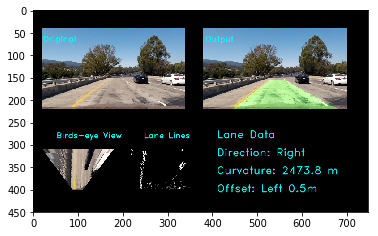

In [43]:
image_path = 'test_images/test1.jpg'
img = cv2.imread(image_path)
img_aug = process_frame(img)
img_aug = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)

cv2.imwrite('output_images/test1_output.jpg',img_aug)

plt.imshow(img_aug)
plt.show()

## VIDEO OUTPUT

In [37]:
from moviepy.editor import VideoFileClip

video_output = 'output_images/project_output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

clip = clip1.fl_image(process_frame)
clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_output_video.mp4
[MoviePy] Writing video output_images/project_output_video.mp4


100%|█████████▉| 1260/1261 [01:44<00:00, 12.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output_video.mp4 

